# KVLCC2 Ikeda method

# Purpose
How good is original Ikeda method for this ship?

# Methodology
Run PyScoresII and calculate Ikeda

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import copy
from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize
import scipy
from copy import deepcopy
import joblib

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import pyscores2
import pyscores2.runScores2
import pyscores2.xml_hydrostatics
from pyscores2.output import OutputFile
from rolldecayestimators.ikeda import Ikeda, IkedaR

from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda, SimplifiedIkedaABS
from rolldecayestimators.simplified_ikeda import limits_kawahara
from pyscores2.runScores2 import Calculation
import shutil
from reports import mdl_results

In [3]:
df_rolldecays=mdl_results.df_rolldecays

In [4]:
row = df_rolldecays.iloc[2]

## Run ScoresII

In [5]:
xml_parser = pyscores2.xml_hydrostatics.Parser(fileName='../../data/external/KVLCC2m_kbk_final_ScoresData.xml')
indata = xml_parser.convertToScores2Indata(conditionName='Design')
indata.runOptions["IJ"].set_value(1)
indata.runOptions["IK"].set_value(2)

In [6]:
indata.kxx = row.KXX*0.78  # To get correct natural frequency
indata.kyy = row.KZZ
indata.speedMax=15.5
indata.speedIncrement=15
indata.waveFrequenciesMax = 1.0
indata.waveFrequenciesMin = 0.3
indata.waveFrequenciesIncrement = 0.015
#indata.zcg = run.loading_condition.kg

In [7]:
indata.save('../../models/KVLCC2_speed.IN')

In [8]:
save_dir_name = 'scores'
if not os.path.exists(save_dir_name):
    os.mkdir(save_dir_name)
    
calculation = Calculation(outDataDirectory='scores')

In [9]:
if os.name == 'nt':
    calculation.run(indata=indata)  # (This only works on windows)
    shutil.copyfile(calculation.outDataPath,'../../data/interim/KVLCC2_speed.out')
else:
    calculation.outDataPath = '../../data/interim/KVLCC2_speed.out'

Running Scores2 for KVLCC2m_kbk_final Design


C:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


## Load ScoresII results

In [12]:
output_file = OutputFile(filePath=calculation.outDataPath)
output_file.results

{0.0: {0.0: <pyscores2.result.Result at 0x2a59b865470>,
  30.0: <pyscores2.result.Result at 0x2a59b865400>,
  60.0: <pyscores2.result.Result at 0x2a59b865518>,
  90.0: <pyscores2.result.Result at 0x2a59b865cc0>,
  120.0: <pyscores2.result.Result at 0x2a59b847a90>,
  150.0: <pyscores2.result.Result at 0x2a59b847a58>,
  180.0: <pyscores2.result.Result at 0x2a59b847d68>},
 15.0: {0.0: <pyscores2.result.Result at 0x2a59b847b70>,
  30.0: <pyscores2.result.Result at 0x2a59b847c50>,
  60.0: <pyscores2.result.Result at 0x2a59b8478d0>,
  90.0: <pyscores2.result.Result at 0x2a59b847198>,
  120.0: <pyscores2.result.Result at 0x2a59b847518>,
  150.0: <pyscores2.result.Result at 0x2a59b847438>,
  180.0: <pyscores2.result.Result at 0x2a59b8470f0>}}

In [13]:
df = output_file.get_result()

In [14]:
df.describe()

,frequencies,encounterFrequencies,waveLengths,heaveAmplitude,heavePhase,pitchAmplitude,pitchPhase,surgeAmplitude,surgePhase,forces,moments,speed,wave direction,swayAmplitude,swayPhase,yawAmplitude,yawPhase,rollAmplitude,rollPhase
count,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,0.468033,0.468033,368.670000,0.552034,103.735714,0.298860,-14.244225,0.234176,4.969453,41.159458,198.457057,7.500000,90.000000,0.347209,64.377872,0.141297,50.977234,0.962086,41.333617
std,0.167776,0.214466,181.225973,0.377948,105.112846,0.198350,85.181421,0.235361,91.020527,43.875515,1409.387936,7.505706,60.045645,0.259896,60.204130,0.099550,103.094235,1.634676,100.136149
min,0.301970,0.213130,61.620000,0.000200,-179.800000,0.001000,-176.400000,0.000000,-175.400000,0.990810,-4040.000000,0.000000,0.000000,0.000900,-166.500000,0.000500,-179.100000,0.000400,-179.600000
25%,0.341330,0.328962,208.470000,0.158850,60.725000,0.082275,-85.175000,0.021250,-87.600000,6.707588,-168.750000,0.000000,30.000000,0.085800,79.675000,0.030850,-10.900000,0.117025,-57.725000
50%,0.408820,0.398135,368.670000,0.602900,163.550000,0.344500,-49.150000,0.190950,32.100000,26.241750,0.000000,7.500000,90.000000,0.306700,89.550000,0.156750,3.600000,0.437800,79.750000
75%,0.543660,0.533963,528.870000,0.902550,174.675000,0.465350,68.175000,0.364600,90.700000,63.642375,490.500000,15.000000,150.000000,0.587325,90.900000,0.218425,172.575000,1.039675,115.825000
max,0.999980,1.786820,675.720000,1.191500,179.400000,0.650000,176.700000,1.047400,166.100000,200.369250,7580.000000,15.000000,180.000000,0.833100,171.200000,0.351600,179.500000,15.787100,177.600000


In [15]:
df.head()

,frequencies,encounterFrequencies,waveLengths,heaveAmplitude,heavePhase,pitchAmplitude,pitchPhase,surgeAmplitude,surgePhase,forces,moments,speed,wave direction,swayAmplitude,swayPhase,yawAmplitude,yawPhase,rollAmplitude,rollPhase
0,0.99998,0.99998,61.62,0.0035,-115.2,0.0041,-116.6,0.0032,-31.6,28.44900,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.90658,0.90658,74.97,0.0075,61.1,0.0090,64.8,0.0036,110.2,32.86350,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0.83526,0.83526,88.32,0.0116,-76.1,0.0207,-51.1,0.0125,136.2,38.74950,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.77849,0.77849,101.67,0.0213,-140.8,0.0327,-151.5,0.0140,-72.2,44.88075,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.73192,0.73192,115.02,0.0272,137.9,0.0636,159.5,0.0326,-64.2,53.95500,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


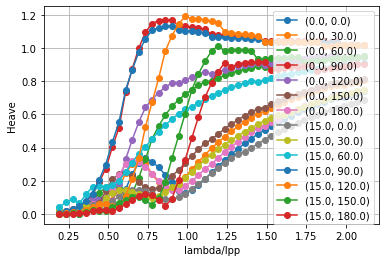

In [16]:
df[r'lambda/lpp'] = df['waveLengths']/row.lpp 


fig,ax=plt.subplots()
for index, group in df.groupby(by=['speed','wave direction']):
    group.plot(x=r'lambda/lpp', y='heaveAmplitude', style='o-', label=index, ax=ax)
    
ax.grid(True)
ax.legend();
ax.set_ylabel('Heave');

In [17]:
RAO_15_0 = df.groupby(by=['speed','wave direction']).get_group((15,180))

<AxesSubplot:xlabel='lambda/lpp'>

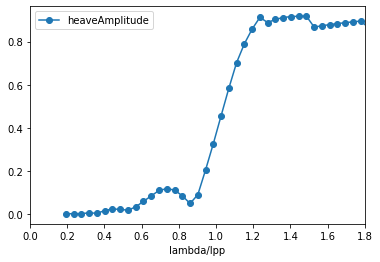

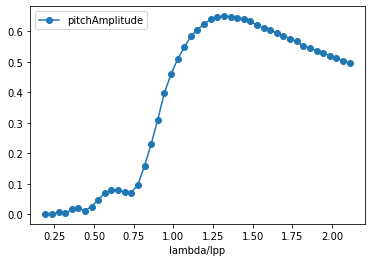

In [18]:
fig,ax=plt.subplots()
RAO_15_0.plot(x=r'lambda/lpp', y='heaveAmplitude', style='o-', ax=ax)
ax.set_xlim((0,1.8))

fig,ax=plt.subplots()
RAO_15_0.plot(x=r'lambda/lpp', y='pitchAmplitude', style='o-', ax=ax)
#ax.set_xlim((0,1.8))

In [19]:
df_roll_damping = output_file.get_roll_damping()
df_roll_damping

,calculated_wave_damping_in_roll,critical_wave_damping_in_roll,natural_roll_frequency,roll_damping_ratio,speed,wave_direction
0,9054.0,7738000.0,0.29838,0.026150,0.0,0.0
1,9054.0,7738000.0,0.29838,0.037180,0.0,30.0
2,9054.0,7738000.0,0.29838,0.041460,0.0,60.0
3,9054.0,7738000.0,0.29838,0.037180,0.0,90.0
4,9054.0,7738000.0,0.29838,0.026120,0.0,120.0
5,NaN,NaN,NaN,NaN,0.0,150.0
6,NaN,NaN,NaN,NaN,0.0,180.0
7,9054.0,7738000.0,0.29838,0.004322,15.0,0.0
8,9054.0,7738000.0,0.29838,0.012690,15.0,30.0
9,9054.0,7738000.0,0.29838,0.041640,15.0,60.0


## Run Ikeda

In [20]:
w = 2.462149630662348

scale_factor=row.scale_factor
V = row.ship_speed*1.852/3.6/np.sqrt(scale_factor)

if not row.BKL:
    BKL=0
else:
    BKL=row.BKL/scale_factor

if not row.BKB:
    BKB = 0
else:
    BKB=row.BKB/scale_factor

kg = row.kg/scale_factor
    
#fi_as = np.deg2rad([1,10])
fi_as = np.deg2rad(10)

ikeda = Ikeda.load_scoresII(V=V, w=w, fi_a=fi_as, indata=indata, output_file=output_file, 
                            scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg)

R = 0.05*row.beam/scale_factor  # Just guessing...
ikeda.R = R

In [21]:
def calculate_ikeda(ikeda):

    output = pd.DataFrame()
    output['B_44_hat']   = ikeda.calculate_B44()
    output['B_W0_hat']   = float(ikeda.calculate_B_W0())
    output['B_W_hat']    = float(ikeda.calculate_B_W())
    output['B_F_hat']    = ikeda.calculate_B_F()
    output['B_E_hat']    = ikeda.calculate_B_E()
    output['B_BK_hat']   = ikeda.calculate_B_BK()
    output['B_L_hat']    = float(ikeda.calculate_B_L())
    output['Bw_div_Bw0'] = float(ikeda.calculate_Bw_div_Bw0())
    return output

In [22]:
result_datas = calculate_ikeda(ikeda)  # DataFrame with two roll amplitudes

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\reports\venv\lib\site-packages\rolldecayestimators\ikeda_speed.py:595: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))


In [23]:
result_datas

,B_44_hat,B_W0_hat,B_W_hat,B_F_hat,B_E_hat,B_BK_hat,B_L_hat,Bw_div_Bw0
0,0.002264,0.000064,0.000303,0.000498,0.000118,0.0,0.001345,4.754679


## Simplified Ikeda also...

In [24]:
lpp = row.lpp/scale_factor
beam = row.beam/scale_factor
kg = row.kg/scale_factor
volume = row.Volume/(scale_factor**3)
draught = (row.TA + row.TF)/2/scale_factor
A0 = row.A0

if not row.BKL:
    BKL=0
else:
    BKL = row.BKL

if not row.BKB:
    BKB = 0
else:
    BKB = row.BKB

si = SimplifiedIkeda(V=V, w=w, fi_a=fi_as, beam=beam, lpp=lpp, kg = kg, volume=volume, draught=draught, A0=A0, BKL=BKL, BKB=BKB)

In [25]:
def calculate_SI(si):
    
    output = pd.DataFrame()
    output['B_44_hat'] = si.calculate_B44()
    output['B_W0_hat'] =si.calculate_B_W0()
    output['B_W_hat'] =si.calculate_B_W()
    output['B_F_hat'] =si.calculate_B_F()
    output['B_E_hat'] =si.calculate_B_E()
    output['B_BK_hat'] =si.calculate_B_BK()
    output['B_L_hat'] =si.calculate_B_L()
    output['Bw_div_Bw0'] =si.calculate_Bw_div_Bw0()
    
    return output

In [26]:
result_datas_SI = calculate_SI(si=si)

In [27]:
result_datas_SI

,B_44_hat,B_W0_hat,B_W_hat,B_F_hat,B_E_hat,B_BK_hat,B_L_hat,Bw_div_Bw0
0,NaN,0.000731,0.003476,0.000296,0.001962,NaN,0.00137,4.754679


In [28]:
df_results = pd.DataFrame(columns=result_datas.columns)
df_results.loc['ikeda']=result_datas.iloc[0]
df_results.loc['SI']=result_datas_SI.iloc[0]


<a id='eddy'></a>

<AxesSubplot:>

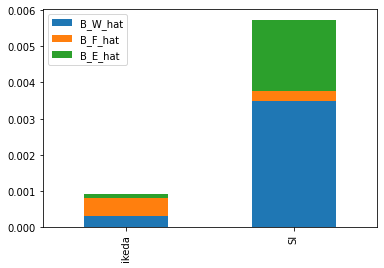

In [29]:
interesting = ['B_W_hat','B_F_hat','B_E_hat']
df_results[interesting].plot(kind='bar',stacked=True)

In [30]:
limits_kawahara

{'CB': (0.5, 0.85),
 'B/d': (2.5, 4.5),
 'OG/d': (-1.5, 0.2),
 'CMID': (0.9, 0.99),
 'bBk/B': (0.01, 0.06),
 'lBk/LPP': (0.05, 0.4),
 'OMEGA_hat': (0, 1.0)}

In [31]:
df_limits = pd.DataFrame(data = limits_kawahara, index = ['min','max']).transpose()
df_limits

,min,max
CB,0.50,0.85
B/d,2.50,4.50
OG/d,-1.50,0.20
CMID,0.90,0.99
bBk/B,0.01,0.06
lBk/LPP,0.05,0.40
OMEGA_hat,0.00,1.00


In [32]:
g=9.81
omega_hat = lambdas.omega_hat(beam=beam, g=g, omega0=w)

In [33]:
Cb = volume/(lpp*beam*draught)
OG = draught-kg
ship_limits = {
 'CB': Cb,
 'B/d': beam/draught,
 'OG/d': OG/draught,
 'CMID': A0,
 'bBk/B': BKB/beam,
 'lBk/LPP': BKL/beam,
 'OMEGA_hat': omega_hat}
ship_limits = pd.Series(ship_limits,name='ship')

In [34]:
df_limits['ship'] = ship_limits

In [35]:
df_limits_clean = df_limits.copy()
if df_limits.loc['bBk/B','ship']==0:
    df_limits_clean.drop('bBk/B', inplace=True)
    
if df_limits.loc['lBk/LPP','ship']==0:
    df_limits_clean.drop('lBk/LPP', inplace=True)

Text(0.5, 1.0, 'Ship vs. SI limits')

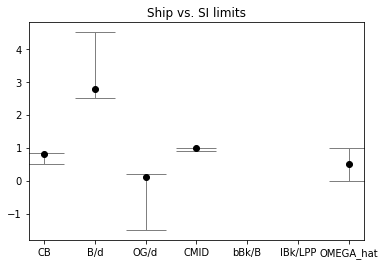

In [36]:
fig,ax=plt.subplots()
ax.errorbar(df_limits_clean.index,df_limits_clean['ship'],yerr=[df_limits_clean['ship']-df_limits_clean['min'],df_limits_clean['max']-df_limits_clean['ship']], 
            fmt='ok', lw=1, ecolor='gray', capsize=20)
ax.set_title('Ship vs. SI limits')

In [37]:
df_ = df_limits_clean.sub(df_limits['min'],axis=0)
df_limits_normalized = df_.div(df_['max'], axis=0)

<a id='limits_kawahara'></a>

Text(0, 0.5, 'Norlimized limit')

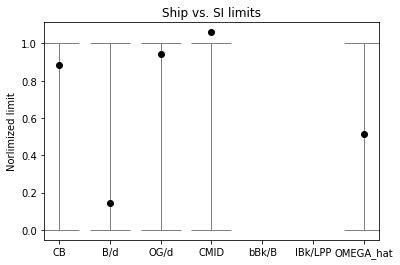

In [38]:
fig,ax=plt.subplots()
ax.errorbar(df_limits_normalized.index,df_limits_normalized['ship'],yerr=[df_limits_normalized['ship']-df_limits_normalized['min'],
                                                                         df_limits_normalized['max']-df_limits_normalized['ship']], fmt='ok', lw=1, ecolor='gray', capsize=20)
ax.set_title('Ship vs. SI limits')
ax.set_ylabel('Norlimized limit')